# Problem Statement

# Maintenance cost reduction through predictive techniques
## BACKGROUND
A company has a fleet of devices transmitting daily telemetry readings. They
would like to create a predictive maintenance solution to proactively identify
when maintenance should be performed. This approach promises cost savings
over routine or time-based preventive maintenance, because tasks are
performed only when warranted.
## GOAL
You are tasked with building a predictive model using machine learning to
predict the probability of a device failure. When building this model, be sure to
**minimize false positives and false negatives.** The column you are trying to
predict is called failure with binary value 0 for non-failure and 1 for failure.

# Importing Libraries


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix



In [2]:
# Load the dataset
data = pd.read_csv("predictive_maintenance.csv")


### Data Exploration and Insights

In [3]:
# Display the first few rows
data.head(10)


date    device  failure    metric1  metric2  metric3  metric4  metric5  \
0  1/1/15  S1F01085        0  215630672       56        0       52        6   
1  1/1/15  S1F0166B        0   61370680        0        3        0        6   
2  1/1/15  S1F01E6Y        0  173295968        0        0        0       12   
3  1/1/15  S1F01JE0        0   79694024        0        0        0        6   
4  1/1/15  S1F01R2B        0  135970480        0        0        0       15   
5  1/1/15  S1F01TD5        0   68837488        0        0       41        6   
6  1/1/15  S1F01XDJ        0  227721632        0        0        0        8   
7  1/1/15  S1F023H2        0  141503600        0        0        1       19   
8  1/1/15  S1F02A0J        0    8217840        0        1        0       14   
9  1/1/15  S1F02DZ2        0  116440096        0      323        9        9   

   metric6  metric7  metric8  metric9  
0   407438        0        0        7  
1   403174        0        0        0  
2   237394        0        0        0  
3   410186        0        0        0  
4   313173        0        0        3  
5   413535        0        0        1  
6   402525        0        0        0  
7   494462       16       16        3  
8   311869        0        0        0  
9   407905        0        0      164

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     124494 non-null  object
 1   device   124494 non-null  object
 2   failure  124494 non-null  int64 
 3   metric1  124494 non-null  int64 
 4   metric2  124494 non-null  int64 
 5   metric3  124494 non-null  int64 
 6   metric4  124494 non-null  int64 
 7   metric5  124494 non-null  int64 
 8   metric6  124494 non-null  int64 
 9   metric7  124494 non-null  int64 
 10  metric8  124494 non-null  int64 
 11  metric9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [5]:
data.count()

date       124494
device     124494
failure    124494
metric1    124494
metric2    124494
metric3    124494
metric4    124494
metric5    124494
metric6    124494
metric7    124494
metric8    124494
metric9    124494
dtype: int64

In [6]:
data.nunique()

date          304
device       1169
failure         2
metric1    123877
metric2       558
metric3        47
metric4       115
metric5        60
metric6     44838
metric7        28
metric8        28
metric9        65
dtype: int64

In [7]:
data.isnull().sum()

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

In [8]:
failure_counts = data["failure"].value_counts()
failure_percentages = failure_counts / len(data) * 100

# Print the results
print("Failure Counts:")
print(failure_counts)
print("\nFailure Percentages:")
print(failure_percentages)


Failure Counts:
0    124388
1       106
Name: failure, dtype: int64

Failure Percentages:
0    99.914855
1     0.085145
Name: failure, dtype: float64


In [9]:
# Filter the dataset for rows where failure = 1
failed_devices = data[data['failure'] == 1]

# Get the total number of unique devices that experienced failure
total_unique_failed_devices = failed_devices['device'].nunique()

print("Total unique failure devices:", total_unique_failed_devices)


Total unique failure devices: 106


In [10]:
# Generate summary statistics for numerical features
print(data.describe())


             failure       metric1        metric2        metric3  \
count  124494.000000  1.244940e+05  124494.000000  124494.000000   
mean        0.000851  1.223881e+08     159.484762       9.940455   
std         0.029167  7.045933e+07    2179.657730     185.747321   
min         0.000000  0.000000e+00       0.000000       0.000000   
25%         0.000000  6.128476e+07       0.000000       0.000000   
50%         0.000000  1.227974e+08       0.000000       0.000000   
75%         0.000000  1.833096e+08       0.000000       0.000000   
max         1.000000  2.441405e+08   64968.000000   24929.000000   

             metric4        metric5        metric6        metric7  \
count  124494.000000  124494.000000  124494.000000  124494.000000   
mean        1.741120      14.222669  260172.657726       0.292528   
std        22.908507      15.943028   99151.078547       7.436924   
min         0.000000       1.000000       8.000000       0.000000   
25%         0.000000       8.000000  22145

The count for metric1 is the same as for the other metrics (124494), but it’s displayed in scientific notation (1.244940e+05) because of the large mean value that follows it in the table.

In [11]:
# Identify all duplicates (including the first occurrence)
duplicates = data.duplicated()

# Count the number of duplicates (excluding the first occurrence)
num_duplicates = duplicates.sum() - duplicates.head(1).sum()

print(f"Number of duplicate rows (excluding first occurrence): {num_duplicates}")

Number of duplicate rows (excluding first occurrence): 1


In [12]:
 ProfileReport(data, minimal=False)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Observation


- The dataset consists of **124,494** entries and **12** columns.
- Columns include 'date', 'device', 'failure', and numerical metrics from 'metric1' to 'metric9'.
- The data is clean there are **no missing values** since the count of non-null values for each column matches the total number of entries (124,494).
- 'date' and 'device' columns are of object data type, while other columns are of integer data type.
- It is **imbalanced data set**, as the failuer class is about **0.1%** of unfailure class. Here oversampling approach is used to deal with imbalanced dataset.

- **'date'** column has **304** unique values, indicating that the dataset spans over multiple days.
- There are total **1,169**  unique devices out of which total unique failure devices: **106**.
- Numerical metrics have varying numbers of unique values, suggesting differences in data distribution and variability across metrics.
- **metric7** and **metric8** seems to **exactly same**, so we can drop one of them
- metric 2,3,4,7,9 are **highly skewed.**

# Feature Engineering

### Date Exploration and Visualization

In [13]:
print("Start Date:", data['date'].min())
print("End Date:", data['date'].max())

Start Date: 1/1/15
End Date: 9/9/15


### Convert Data Types
- Convert the 'date' column to datetime data type.

In [14]:
# 2. Convert data types
# Convert 'date' column to datetime data type
data['date'] = pd.to_datetime(data['date'])

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   date     124494 non-null  datetime64[ns]
 1   device   124494 non-null  object        
 2   failure  124494 non-null  int64         
 3   metric1  124494 non-null  int64         
 4   metric2  124494 non-null  int64         
 5   metric3  124494 non-null  int64         
 6   metric4  124494 non-null  int64         
 7   metric5  124494 non-null  int64         
 8   metric6  124494 non-null  int64         
 9   metric7  124494 non-null  int64         
 10  metric8  124494 non-null  int64         
 11  metric9  124494 non-null  int64         
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 11.4+ MB


### Extract Date Features
#### Create new features:
- 'month': Extract the month from the 'date' column.
- 'weekday': Extract the day of the week from the 'date' column.

In [16]:
 data['month'] = data['date'].dt.month

In [17]:
data['weekday'] = data['date'].dt.dayofweek
data

date    device  failure    metric1  metric2  metric3  metric4  \
0      2015-01-01  S1F01085        0  215630672       56        0       52   
1      2015-01-01  S1F0166B        0   61370680        0        3        0   
2      2015-01-01  S1F01E6Y        0  173295968        0        0        0   
3      2015-01-01  S1F01JE0        0   79694024        0        0        0   
4      2015-01-01  S1F01R2B        0  135970480        0        0        0   
...           ...       ...      ...        ...      ...      ...      ...   
124489 2015-11-02  Z1F0MA1S        0   18310224        0        0        0   
124490 2015-11-02  Z1F0Q8RT        0  172556680       96      107        4   
124491 2015-11-02  Z1F0QK05        0   19029120     4832        0        0   
124492 2015-11-02  Z1F0QL3N        0  226953408        0        0        0   
124493 2015-11-02  Z1F0QLC1        0   17572840        0        0        0   

        metric5  metric6  metric7  metric8  metric9  month  weekday  
0             6   407438        0        0        7      1        3  
1             6   403174        0        0        0      1        3  
2            12   237394        0        0        0      1        3  
3             6   410186        0        0        0      1        3  
4            15   313173        0        0        3      1        3  
...         ...      ...      ...      ...      ...    ...      ...  
124489       10   353705        8        8        0     11        0  
124490       11   332792        0        0       13     11        0  
124491       11   350410        0        0        0     11        0  
124492       12   358980        0        0        0     11        0  
124493       10   351431        0        0        0     11        0  

[124494 rows x 14 columns]

Grouping the unique device numbers in Months 

In [18]:
data.groupby('month').agg({'device':lambda x: x.nunique()})

device
month        
1        1164
2         726
3         685
4         491
5         424
6         353
7         346
8         334
9         184
10        146
11         31

<Axes: xlabel='month'>

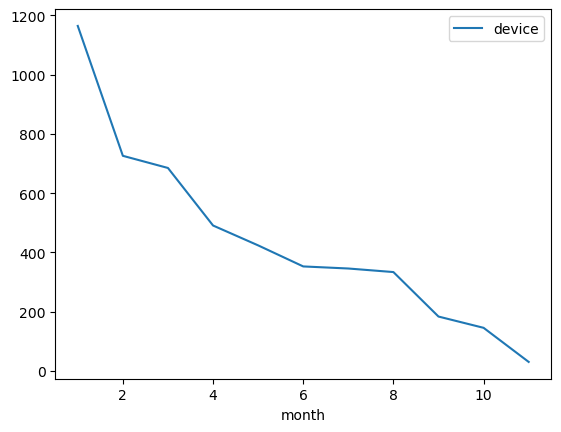

In [19]:
data.groupby('month').agg({'device':lambda x: x.nunique()}).plot()

In [20]:
data.groupby(data['date'].dt.month)['failure'].value_counts().unstack(fill_value=0)


failure      0   1
date              
1        25008  24
2        19486  14
3        19824   9
4        12003   9
5        11309  21
6        10463   6
7        10515  16
8         8342   4
9         4470   0
10        2937   3
11          31   0

### Last Recorded Date of Telemetry for Each Device
- **Latest Dates:** The last recorded date of telemetry for each device.

In [21]:

data.groupby('device')['date'].max()




device
S1F01085   2015-01-06
S1F013BB   2015-05-11
S1F0166B   2015-01-06
S1F01E6Y   2015-02-17
S1F01JE0   2015-01-06
              ...    
Z1F1VMZB   2015-10-19
Z1F1VQFY   2015-06-30
Z1F26YZB   2015-03-25
Z1F282ZV   2015-03-25
Z1F2PBHX   2015-04-06
Name: date, Length: 1169, dtype: datetime64[ns]

In [22]:
data['max_date_per_device'] = data.groupby('device')['date'].transform('max')


In [23]:
data

date    device  failure    metric1  metric2  metric3  metric4  \
0      2015-01-01  S1F01085        0  215630672       56        0       52   
1      2015-01-01  S1F0166B        0   61370680        0        3        0   
2      2015-01-01  S1F01E6Y        0  173295968        0        0        0   
3      2015-01-01  S1F01JE0        0   79694024        0        0        0   
4      2015-01-01  S1F01R2B        0  135970480        0        0        0   
...           ...       ...      ...        ...      ...      ...      ...   
124489 2015-11-02  Z1F0MA1S        0   18310224        0        0        0   
124490 2015-11-02  Z1F0Q8RT        0  172556680       96      107        4   
124491 2015-11-02  Z1F0QK05        0   19029120     4832        0        0   
124492 2015-11-02  Z1F0QL3N        0  226953408        0        0        0   
124493 2015-11-02  Z1F0QLC1        0   17572840        0        0        0   

        metric5  metric6  metric7  metric8  metric9  month  weekday  \
0             6   407438        0        0        7      1        3   
1             6   403174        0        0        0      1        3   
2            12   237394        0        0        0      1        3   
3             6   410186        0        0        0      1        3   
4            15   313173        0        0        3      1        3   
...         ...      ...      ...      ...      ...    ...      ...   
124489       10   353705        8        8        0     11        0   
124490       11   332792        0        0       13     11        0   
124491       11   350410        0        0        0     11        0   
124492       12   358980        0        0        0     11        0   
124493       10   351431        0        0        0     11        0   

       max_date_per_device  
0               2015-01-06  
1               2015-01-06  
2               2015-02-17  
3               2015-01-06  
4               2015-08-24  
...                    ...  
124489          2015-11-02  
124490          2015-11-02  
124491          2015-11-02  
124492          2015-11-02  
124493          2015-11-02  

[124494 rows x 15 columns]

 ### last recorded date of telemetry for each device

In [24]:
latest_dates = data.groupby('device')['date'].transform(max)
df1 = data[data['date'] == latest_dates].copy()


In [25]:
df1

date    device  failure    metric1  metric2  metric3  metric4  \
3051   2015-01-03  W1F0WJFT        0  142903640        0        0        0   
3516   2015-01-04  S1F04KSC        0  243217648      392    24929      529   
4673   2015-01-05  S1F03RV3        0   13723560        0        0        0   
4685   2015-01-05  S1F05NAJ        0  201934440      392        0        0   
4686   2015-01-05  S1F05P51        0   12164440      512        0        0   
...           ...       ...      ...        ...      ...      ...      ...   
124489 2015-11-02  Z1F0MA1S        0   18310224        0        0        0   
124490 2015-11-02  Z1F0Q8RT        0  172556680       96      107        4   
124491 2015-11-02  Z1F0QK05        0   19029120     4832        0        0   
124492 2015-11-02  Z1F0QL3N        0  226953408        0        0        0   
124493 2015-11-02  Z1F0QLC1        0   17572840        0        0        0   

        metric5  metric6  metric7  metric8  metric9  month  weekday  \
3051          9   217819        0        0        1      1        5   
3516          3   339302        0        0    10137      1        6   
4673          8   263330        0        0        0      1        0   
4685          4   341352        0        0        1      1        0   
4686          5   335898        0        0        0      1        0   
...         ...      ...      ...      ...      ...    ...      ...   
124489       10   353705        8        8        0     11        0   
124490       11   332792        0        0       13     11        0   
124491       11   350410        0        0        0     11        0   
124492       12   358980        0        0        0     11        0   
124493       10   351431        0        0        0     11        0   

       max_date_per_device  
3051            2015-01-03  
3516            2015-01-04  
4673            2015-01-05  
4685            2015-01-05  
4686            2015-01-05  
...                    ...  
124489          2015-11-02  
124490          2015-11-02  
124491          2015-11-02  
124492          2015-11-02  
124493          2015-11-02  

[1169 rows x 15 columns]

#### Create feature called 'failure_before'

If we just take the last record for the devices, we may lose information from those come back after failed ones


In [26]:
potential_fixed_devices = data[(data['failure'] == 1) & (data['date'] != data['max_date_per_device'])]
potential_fixed_devices


date    device  failure    metric1  metric2  metric3  metric4  \
77958  2015-05-05  S1F136J0        1  131519808        0        0       25   
79590  2015-05-09  W1F0KCP2        1  176861128    10392        0      121   
79601  2015-05-09  W1F0M35B        1  141805096        0        0        1   
101999 2015-07-12  S1F0GPFZ        1  236544080        0        0        0   
104223 2015-07-18  W1F11ZG9        1   32671632      368        9      486   

        metric5  metric6  metric7  metric8  metric9  month  weekday  \
77958        16   343464        8        8        0      5        1   
79590         6   310699        0        0        0      5        5   
79601         7   267203        0        0        0      5        5   
101999        9   264594        0        0        0      7        6   
104223        3   344433        0        0        1      7        5   

       max_date_per_device  
77958           2015-05-06  
79590           2015-05-11  
79601           2015-05-11  
101999          2015-07-24  
104223          2015-08-17

In [27]:
df1.loc[:, 'failure_before'] = 0


In [28]:
df1.loc[df1.device == 'S1F136J0','failure_before'] = 1
df1.loc[df1.device == 'W1F0KCP2','failure_before'] = 1
df1.loc[df1.device == 'W1F0M35B','failure_before'] = 1
df1.loc[df1.device == 'S1F0GPFZ','failure_before'] = 1
df1.loc[df1.device == 'W1F11ZG9','failure_before'] = 1

In [29]:
df1.head(10)

date    device  failure    metric1  metric2  metric3  metric4  \
3051 2015-01-03  W1F0WJFT        0  142903640        0        0        0   
3516 2015-01-04  S1F04KSC        0  243217648      392    24929      529   
4673 2015-01-05  S1F03RV3        0   13723560        0        0        0   
4685 2015-01-05  S1F05NAJ        0  201934440      392        0        0   
4686 2015-01-05  S1F05P51        0   12164440      512        0        0   
4687 2015-01-05  S1F05P5Z        0   56574384      936        0        3   
4692 2015-01-05  S1F08R94        0   16377144        0        1        0   
4693 2015-01-05  S1F08S38        0  120628960      760        3        2   
4695 2015-01-05  S1F09MAK        0   97346208     8392        0        7   
4696 2015-01-05  S1F09MSM        0  234536728      360        0        0   

      metric5  metric6  metric7  metric8  metric9  month  weekday  \
3051        9   217819        0        0        1      1        5   
3516        3   339302        0        0    10137      1        6   
4673        8   263330        0        0        0      1        0   
4685        4   341352        0        0        1      1        0   
4686        5   335898        0        0        0      1        0   
4687        4   335893        0        0        0      1        0   
4692        4   330296        0        0        0      1        0   
4693        4   338658        0        0        6      1        0   
4695        3   306534        0        0        4      1        0   
4696        3   343127        0        0        2      1        0   

     max_date_per_device  failure_before  
3051          2015-01-03               0  
3516          2015-01-04               0  
4673          2015-01-05               0  
4685          2015-01-05               0  
4686          2015-01-05               0  
4687          2015-01-05               0  
4692          2015-01-05               0  
4693          2015-01-05               0  
4695          2015-01-05               0  
4696          2015-01-05               0

This feature engineering process enhances the dataset by extracting meaningful information from the 'date' column and creating a new feature to capture whether a device experienced a failure before the last recorded date.

### Data Transformation and Preprocessing

 **Data Overview**

The dataset df1 contains 1169 entries and 15 columns after feature engineering.

In [30]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169 entries, 3051 to 124493
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 1169 non-null   datetime64[ns]
 1   device               1169 non-null   object        
 2   failure              1169 non-null   int64         
 3   metric1              1169 non-null   int64         
 4   metric2              1169 non-null   int64         
 5   metric3              1169 non-null   int64         
 6   metric4              1169 non-null   int64         
 7   metric5              1169 non-null   int64         
 8   metric6              1169 non-null   int64         
 9   metric7              1169 non-null   int64         
 10  metric8              1169 non-null   int64         
 11  metric9              1169 non-null   int64         
 12  month                1169 non-null   int64         
 13  weekday              1169 no

In [31]:
failure_counts = df1["failure"].value_counts()
failure_percentages = failure_counts / len(df1) * 100

# Print the results
print("Failure Counts:")
print(failure_counts)
print("\nFailure Percentages:")
print(failure_percentages)


Failure Counts:
0    1068
1     101
Name: failure, dtype: int64

Failure Percentages:
0    91.360137
1     8.639863
Name: failure, dtype: float64


In [32]:
df1.device

3051      W1F0WJFT
3516      S1F04KSC
4673      S1F03RV3
4685      S1F05NAJ
4686      S1F05P51
            ...   
124489    Z1F0MA1S
124490    Z1F0Q8RT
124491    Z1F0QK05
124492    Z1F0QL3N
124493    Z1F0QLC1
Name: device, Length: 1169, dtype: object

### Device Identification
- Extract the first four characters of device IDs to group devices for analysis.

In [33]:
Id = df1.device.values.tolist()

In [34]:
#change device id values to the first four characters
Id1 = [] 
for i in Id:
    i = i[:4]
    Id1.append(i)

df1.device=Id1

df1.device.value_counts()

S1F0    391
W1F0    282
Z1F0    149
S1F1    139
W1F1    138
Z1F1     67
Z1F2      3
Name: device, dtype: int64

### Visualizing Failure by Device

Plotting the distribution of failures by device provides insights into failure patterns.

In [35]:
dev=pd.crosstab(df1['device'],df1['failure']) 

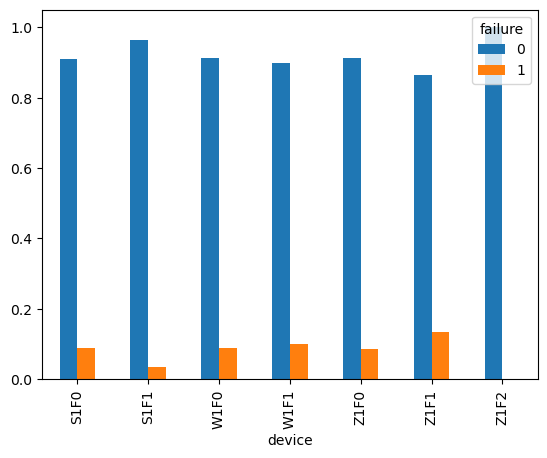

In [36]:
dev.div(dev.sum(1).astype(float), axis=0).plot(kind="bar")
plt.show()

From the Barplot we can say that Devices ID which begins with ZIF1 fails the most, then W1F1 second
 

### Dropping Unimportant and Redundant Data
We have seen earlier that metrics7 and metric8 is highly correlated.
Remove redundant feature 'metric8' and temporal features 'date' and 'max_date_per_device'.

In [37]:
(df1['metric7']==df1['metric8']).value_counts()

True    1169
dtype: int64

In [38]:
df1.drop('metric8',axis=1,inplace=True)

In [39]:
df1.drop(['date','max_date_per_device'],axis=1,inplace=True)

In [40]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169 entries, 3051 to 124493
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   device          1169 non-null   object
 1   failure         1169 non-null   int64 
 2   metric1         1169 non-null   int64 
 3   metric2         1169 non-null   int64 
 4   metric3         1169 non-null   int64 
 5   metric4         1169 non-null   int64 
 6   metric5         1169 non-null   int64 
 7   metric6         1169 non-null   int64 
 8   metric7         1169 non-null   int64 
 9   metric9         1169 non-null   int64 
 10  month           1169 non-null   int64 
 11  weekday         1169 non-null   int64 
 12  failure_before  1169 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 127.9+ KB



Convert categorical features 'month' and 'weekday' to object data type for encoding.

In [41]:
for col in ['month','weekday']:
    df1[col]=df1[col].astype('object')

In [42]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169 entries, 3051 to 124493
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   device          1169 non-null   object
 1   failure         1169 non-null   int64 
 2   metric1         1169 non-null   int64 
 3   metric2         1169 non-null   int64 
 4   metric3         1169 non-null   int64 
 5   metric4         1169 non-null   int64 
 6   metric5         1169 non-null   int64 
 7   metric6         1169 non-null   int64 
 8   metric7         1169 non-null   int64 
 9   metric9         1169 non-null   int64 
 10  month           1169 non-null   object
 11  weekday         1169 non-null   object
 12  failure_before  1169 non-null   int64 
dtypes: int64(10), object(3)
memory usage: 127.9+ KB


### Getting Dummy Variables

To prepare the categorical variables for modeling, we convert them into dummy variables using one-hot encoding.

In [43]:
# Convert categorical variables into dummy variables
df1 = pd.get_dummies(df1, drop_first=True)


C:\Users\DELL\AppData\Local\Temp\ipykernel_18964\842490473.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df1 = pd.get_dummies(df1, drop_first=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_18964\842490473.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df1 = pd.get_dummies(df1, drop_first=True)


In [44]:
df1

failure    metric1  metric2  metric3  metric4  metric5  metric6  \
3051          0  142903640        0        0        0        9   217819   
3516          0  243217648      392    24929      529        3   339302   
4673          0   13723560        0        0        0        8   263330   
4685          0  201934440      392        0        0        4   341352   
4686          0   12164440      512        0        0        5   335898   
...         ...        ...      ...      ...      ...      ...      ...   
124489        0   18310224        0        0        0       10   353705   
124490        0  172556680       96      107        4       11   332792   
124491        0   19029120     4832        0        0       11   350410   
124492        0  226953408        0        0        0       12   358980   
124493        0   17572840        0        0        0       10   351431   

        metric7  metric9  failure_before  ...  month_8  month_9  month_10  \
3051          0        1               0  ...        0        0         0   
3516          0    10137               0  ...        0        0         0   
4673          0        0               0  ...        0        0         0   
4685          0        1               0  ...        0        0         0   
4686          0        0               0  ...        0        0         0   
...         ...      ...             ...  ...      ...      ...       ...   
124489        8        0               0  ...        0        0         0   
124490        0       13               0  ...        0        0         0   
124491        0        0               0  ...        0        0         0   
124492        0        0               0  ...        0        0         0   
124493        0        0               0  ...        0        0         0   

        month_11  weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  \
3051           0          0          0          0          0          1   
3516           0          0          0          0          0          0   
4673           0          0          0          0          0          0   
4685           0          0          0          0          0          0   
4686           0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
124489         1          0          0          0          0          0   
124490         1          0          0          0          0          0   
124491         1          0          0          0          0          0   
124492         1          0          0          0          0          0   
124493         1          0          0          0          0          0   

        weekday_6  
3051            0  
3516            1  
4673            0  
4685            0  
4686            0  
...           ...  
124489          0  
124490          0  
124491          0  
124492          0  
124493          0  

[1169 rows x 32 columns]

### Handling Skewness

Several numerical features exhibit high skewness, particularly metric2, metric3, metric4, metric7, and metric9. We visualize and mitigate this skewness using log transformation.

In [45]:
# Select the columns for visualization and transformation
skewed_columns = ['metric2', 'metric3', 'metric4', 'metric7', 'metric9']


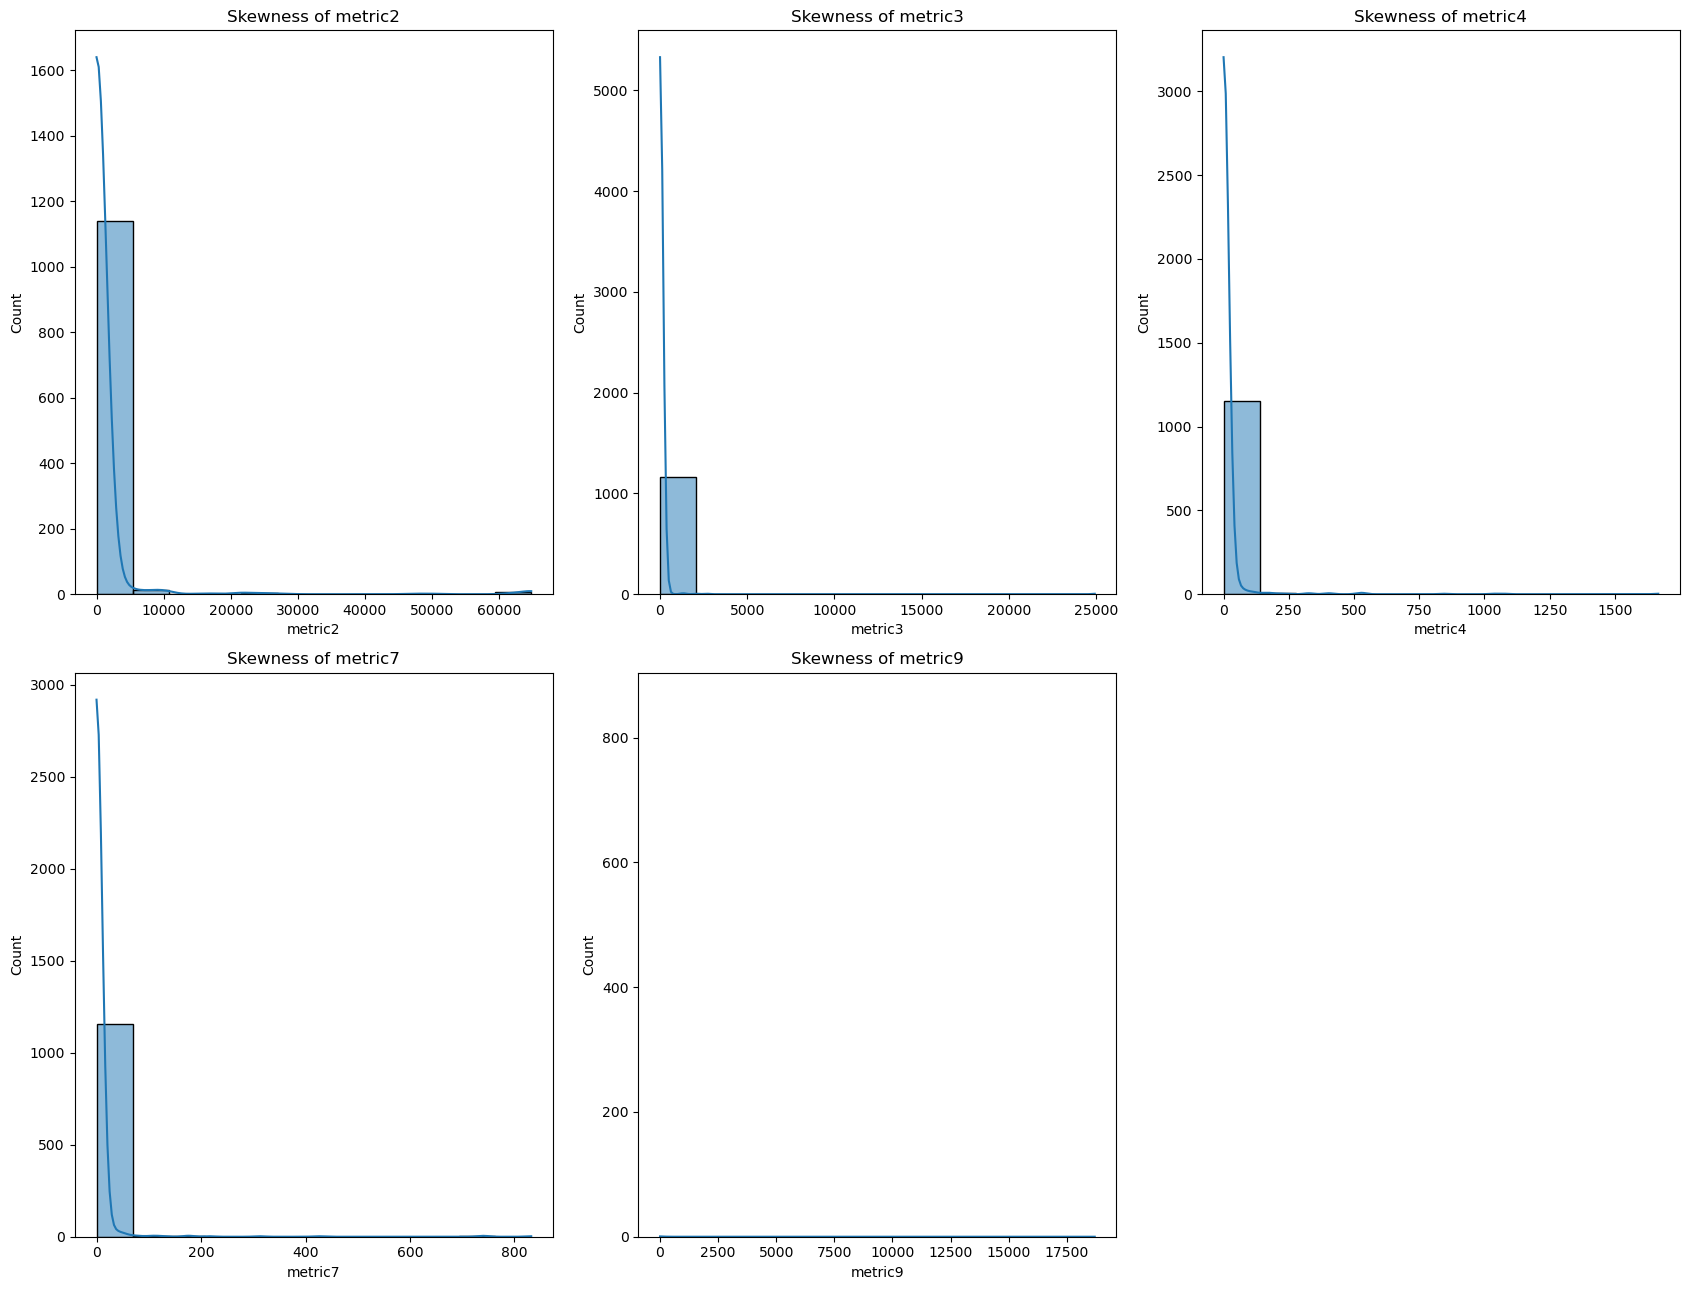

In [46]:
# Visualize the skewness of the selected metrics using histograms
plt.figure(figsize=(17, 13))
for i, column in enumerate(skewed_columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data=df1[column], kde=True)
    plt.title(f'Skewness of {column}')

plt.tight_layout()
plt.show()

In [47]:
df1

failure    metric1  metric2  metric3  metric4  metric5  metric6  \
3051          0  142903640        0        0        0        9   217819   
3516          0  243217648      392    24929      529        3   339302   
4673          0   13723560        0        0        0        8   263330   
4685          0  201934440      392        0        0        4   341352   
4686          0   12164440      512        0        0        5   335898   
...         ...        ...      ...      ...      ...      ...      ...   
124489        0   18310224        0        0        0       10   353705   
124490        0  172556680       96      107        4       11   332792   
124491        0   19029120     4832        0        0       11   350410   
124492        0  226953408        0        0        0       12   358980   
124493        0   17572840        0        0        0       10   351431   

        metric7  metric9  failure_before  ...  month_8  month_9  month_10  \
3051          0        1               0  ...        0        0         0   
3516          0    10137               0  ...        0        0         0   
4673          0        0               0  ...        0        0         0   
4685          0        1               0  ...        0        0         0   
4686          0        0               0  ...        0        0         0   
...         ...      ...             ...  ...      ...      ...       ...   
124489        8        0               0  ...        0        0         0   
124490        0       13               0  ...        0        0         0   
124491        0        0               0  ...        0        0         0   
124492        0        0               0  ...        0        0         0   
124493        0        0               0  ...        0        0         0   

        month_11  weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  \
3051           0          0          0          0          0          1   
3516           0          0          0          0          0          0   
4673           0          0          0          0          0          0   
4685           0          0          0          0          0          0   
4686           0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
124489         1          0          0          0          0          0   
124490         1          0          0          0          0          0   
124491         1          0          0          0          0          0   
124492         1          0          0          0          0          0   
124493         1          0          0          0          0          0   

        weekday_6  
3051            0  
3516            1  
4673            0  
4685            0  
4686            0  
...           ...  
124489          0  
124490          0  
124491          0  
124492          0  
124493          0  

[1169 rows x 32 columns]

In [48]:
# Apply log transformation to handle skewness
for column in skewed_columns:
    df1[column] = np.log1p(df1[column])  # Apply log1p transformation


In [49]:
df1

failure    metric1   metric2    metric3   metric4  metric5  metric6  \
3051          0  142903640  0.000000   0.000000  0.000000        9   217819   
3516          0  243217648  5.973810  10.123827  6.272877        3   339302   
4673          0   13723560  0.000000   0.000000  0.000000        8   263330   
4685          0  201934440  5.973810   0.000000  0.000000        4   341352   
4686          0   12164440  6.240276   0.000000  0.000000        5   335898   
...         ...        ...       ...        ...       ...      ...      ...   
124489        0   18310224  0.000000   0.000000  0.000000       10   353705   
124490        0  172556680  4.574711   4.682131  1.609438       11   332792   
124491        0   19029120  8.483223   0.000000  0.000000       11   350410   
124492        0  226953408  0.000000   0.000000  0.000000       12   358980   
124493        0   17572840  0.000000   0.000000  0.000000       10   351431   

         metric7   metric9  failure_before  ...  month_8  month_9  month_10  \
3051    0.000000  0.693147               0  ...        0        0         0   
3516    0.000000  9.224046               0  ...        0        0         0   
4673    0.000000  0.000000               0  ...        0        0         0   
4685    0.000000  0.693147               0  ...        0        0         0   
4686    0.000000  0.000000               0  ...        0        0         0   
...          ...       ...             ...  ...      ...      ...       ...   
124489  2.197225  0.000000               0  ...        0        0         0   
124490  0.000000  2.639057               0  ...        0        0         0   
124491  0.000000  0.000000               0  ...        0        0         0   
124492  0.000000  0.000000               0  ...        0        0         0   
124493  0.000000  0.000000               0  ...        0        0         0   

        month_11  weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  \
3051           0          0          0          0          0          1   
3516           0          0          0          0          0          0   
4673           0          0          0          0          0          0   
4685           0          0          0          0          0          0   
4686           0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
124489         1          0          0          0          0          0   
124490         1          0          0          0          0          0   
124491         1          0          0          0          0          0   
124492         1          0          0          0          0          0   
124493         1          0          0          0          0          0   

        weekday_6  
3051            0  
3516            1  
4673            0  
4685            0  
4686            0  
...           ...  
124489          0  
124490          0  
124491          0  
124492          0  
124493          0  

[1169 rows x 32 columns]

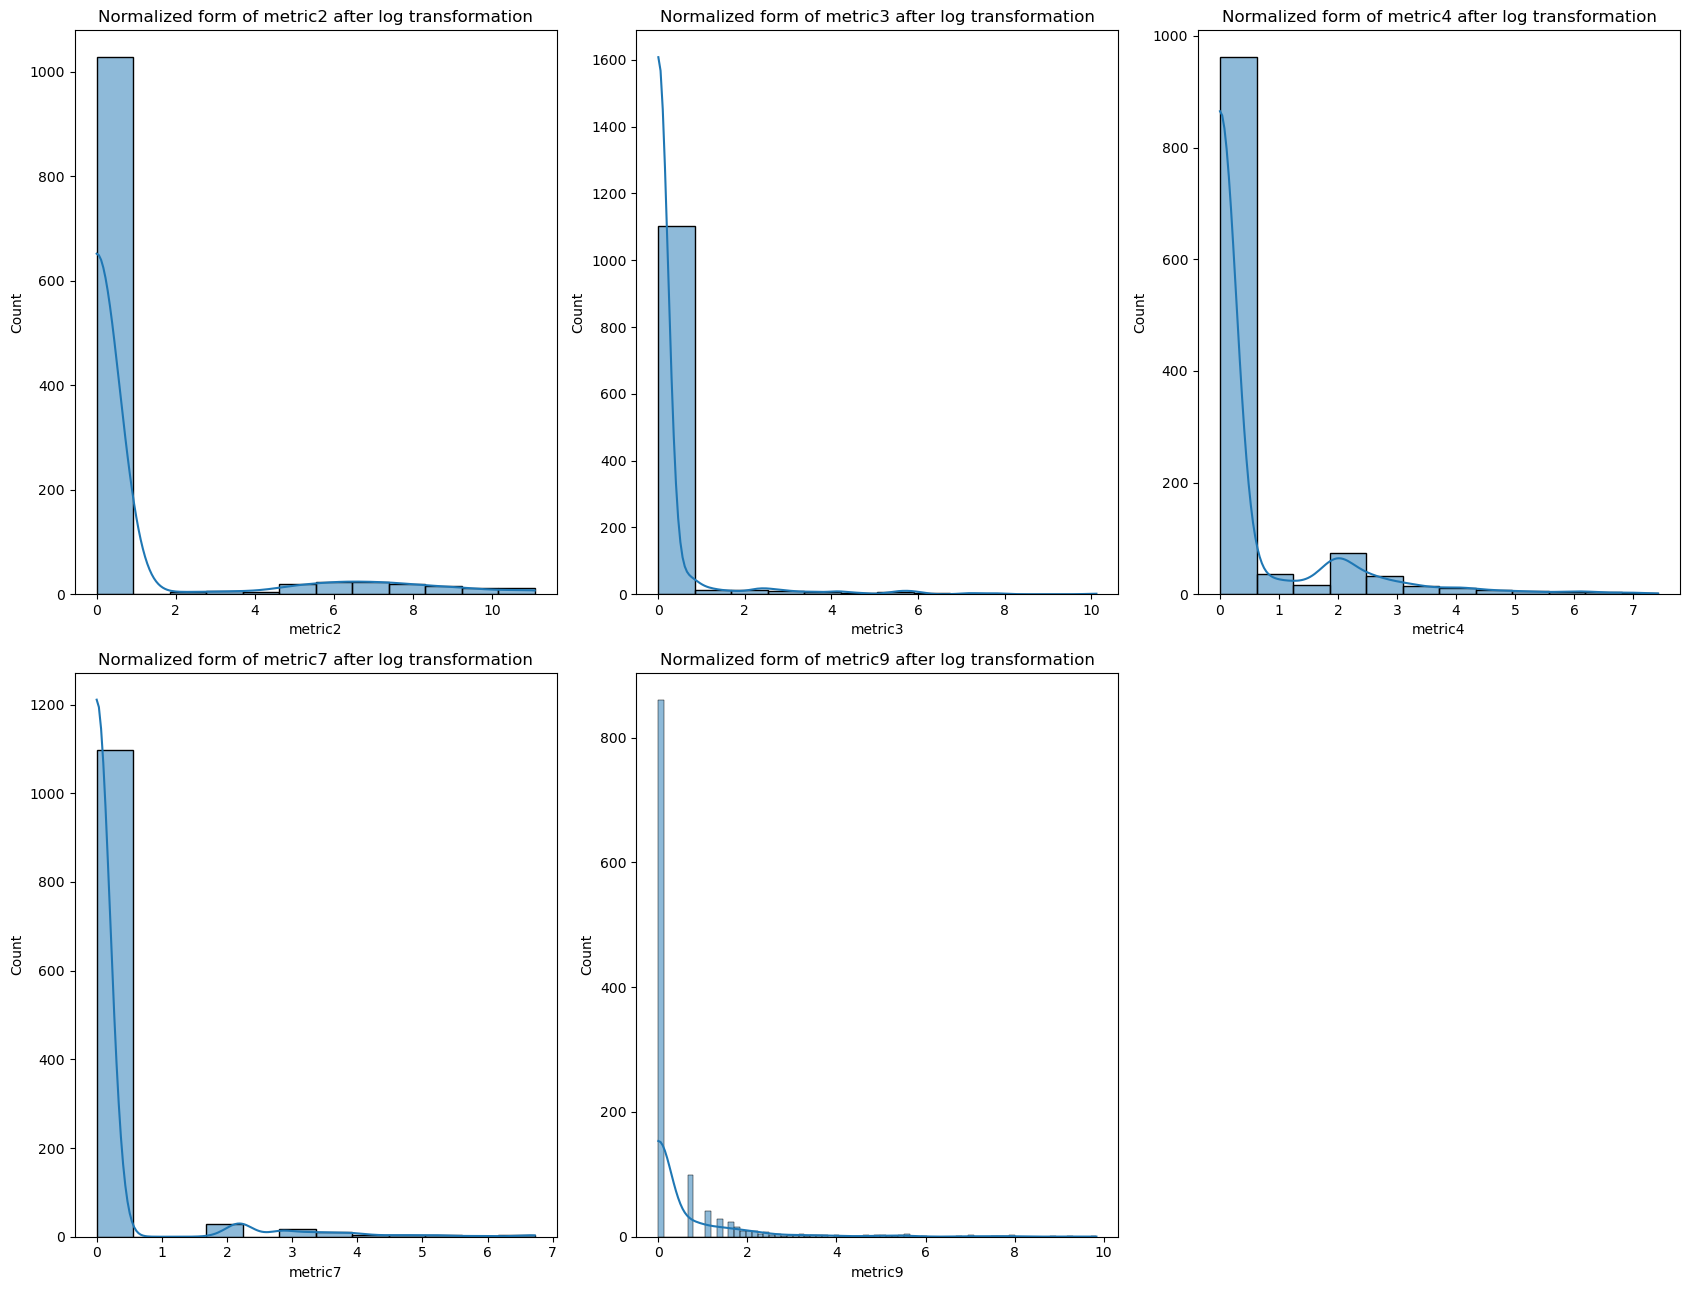

In [50]:
# Visualize the normalized form after log transformation
plt.figure(figsize=(17, 13))
for i, column in enumerate(skewed_columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data=df1[column], kde=True)
    plt.title(f'Normalized form of {column} after log transformation')

plt.tight_layout()
plt.show()

### Feature Scaling or Standardization

Before fitting the data to machine learning models, we scale the numerical features to a standard scale using StandardScaler.

In [51]:
# Separate dependent (y) and independent features (X)
X = df1.drop('failure', axis=1)
y = df1['failure']


In [52]:
y

3051      0
3516      0
4673      0
4685      0
4686      0
         ..
124489    0
124490    0
124491    0
124492    0
124493    0
Name: failure, Length: 1169, dtype: int64

In [53]:
# Select only numeric columns for metrics 1, 2, 3, 4, 5, 6, 7, and 9
numeric_cols = ['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric9']


In [54]:
# Store a copy of X before scaling
X_before_scaling = X.copy()

# Apply StandardScaler only to selected numeric columns
scaler = StandardScaler()
X.loc[:, numeric_cols] = scaler.fit_transform(X.loc[:, numeric_cols])


In [55]:
X

metric1   metric2    metric3   metric4   metric5   metric6   metric7  \
3051    0.294754 -0.351631  -0.228395 -0.393875 -0.278688 -0.498611 -0.236793   
3516    1.720234  2.153516  10.746969  5.172304 -0.764091  0.663122 -0.236793   
4673   -1.540918 -0.351631  -0.228395 -0.393875 -0.359588 -0.063393 -0.236793   
4685    1.133592  2.153516  -0.228395 -0.393875 -0.683190  0.682726 -0.236793   
4686   -1.563074  2.265260  -0.228395 -0.393875 -0.602290  0.630570 -0.236793   
...          ...       ...        ...       ...       ...       ...       ...   
124489 -1.475741 -0.351631  -0.228395 -0.393875 -0.197787  0.800857  2.403312   
124490  0.716129  1.566797   4.847560  1.034245 -0.116887  0.600867 -0.236793   
124491 -1.465526  3.205851  -0.228395 -0.393875 -0.116887  0.769347 -0.236793   
124492  1.489116 -0.351631  -0.228395 -0.393875 -0.035987  0.851301 -0.236793   
124493 -1.486220 -0.351631  -0.228395 -0.393875 -0.197787  0.779111 -0.236793   

         metric9  failure_before  device_S1F1  ...  month_8  month_9  \
3051    0.154236               0            0  ...        0        0   
3516    7.179974               0            0  ...        0        0   
4673   -0.416615               0            0  ...        0        0   
4685    0.154236               0            0  ...        0        0   
4686   -0.416615               0            0  ...        0        0   
...          ...             ...          ...  ...      ...      ...   
124489 -0.416615               0            0  ...        0        0   
124490  1.756817               0            0  ...        0        0   
124491 -0.416615               0            0  ...        0        0   
124492 -0.416615               0            0  ...        0        0   
124493 -0.416615               0            0  ...        0        0   

        month_10  month_11  weekday_1  weekday_2  weekday_3  weekday_4  \
3051           0         0          0          0          0          0   
3516           0         0          0          0          0          0   
4673           0         0          0          0          0          0   
4685           0         0          0          0          0          0   
4686           0         0          0          0          0          0   
...          ...       ...        ...        ...        ...        ...   
124489         0         1          0          0          0          0   
124490         0         1          0          0          0          0   
124491         0         1          0          0          0          0   
124492         0         1          0          0          0          0   
124493         0         1          0          0          0          0   

        weekday_5  weekday_6  
3051            1          0  
3516            0          1  
4673            0          0  
4685            0          0  
4686            0          0  
...           ...        ...  
124489          0          0  
124490          0          0  
124491          0          0  
124492          0          0  
124493          0          0  

[1169 rows x 31 columns]

In [56]:
X_before_scaling

metric1   metric2    metric3   metric4  metric5  metric6   metric7  \
3051    142903640  0.000000   0.000000  0.000000        9   217819  0.000000   
3516    243217648  5.973810  10.123827  6.272877        3   339302  0.000000   
4673     13723560  0.000000   0.000000  0.000000        8   263330  0.000000   
4685    201934440  5.973810   0.000000  0.000000        4   341352  0.000000   
4686     12164440  6.240276   0.000000  0.000000        5   335898  0.000000   
...           ...       ...        ...       ...      ...      ...       ...   
124489   18310224  0.000000   0.000000  0.000000       10   353705  2.197225   
124490  172556680  4.574711   4.682131  1.609438       11   332792  0.000000   
124491   19029120  8.483223   0.000000  0.000000       11   350410  0.000000   
124492  226953408  0.000000   0.000000  0.000000       12   358980  0.000000   
124493   17572840  0.000000   0.000000  0.000000       10   351431  0.000000   

         metric9  failure_before  device_S1F1  ...  month_8  month_9  \
3051    0.693147               0            0  ...        0        0   
3516    9.224046               0            0  ...        0        0   
4673    0.000000               0            0  ...        0        0   
4685    0.693147               0            0  ...        0        0   
4686    0.000000               0            0  ...        0        0   
...          ...             ...          ...  ...      ...      ...   
124489  0.000000               0            0  ...        0        0   
124490  2.639057               0            0  ...        0        0   
124491  0.000000               0            0  ...        0        0   
124492  0.000000               0            0  ...        0        0   
124493  0.000000               0            0  ...        0        0   

        month_10  month_11  weekday_1  weekday_2  weekday_3  weekday_4  \
3051           0         0          0          0          0          0   
3516           0         0          0          0          0          0   
4673           0         0          0          0          0          0   
4685           0         0          0          0          0          0   
4686           0         0          0          0          0          0   
...          ...       ...        ...        ...        ...        ...   
124489         0         1          0          0          0          0   
124490         0         1          0          0          0          0   
124491         0         1          0          0          0          0   
124492         0         1          0          0          0          0   
124493         0         1          0          0          0          0   

        weekday_5  weekday_6  
3051            1          0  
3516            0          1  
4673            0          0  
4685            0          0  
4686            0          0  
...           ...        ...  
124489          0          0  
124490          0          0  
124491          0          0  
124492          0          0  
124493          0          0  

[1169 rows x 31 columns]

## Box Plots To understand Effect Of Standard Scaler

C:\Users\DELL\AppData\Local\Temp\ipykernel_18964\294943947.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


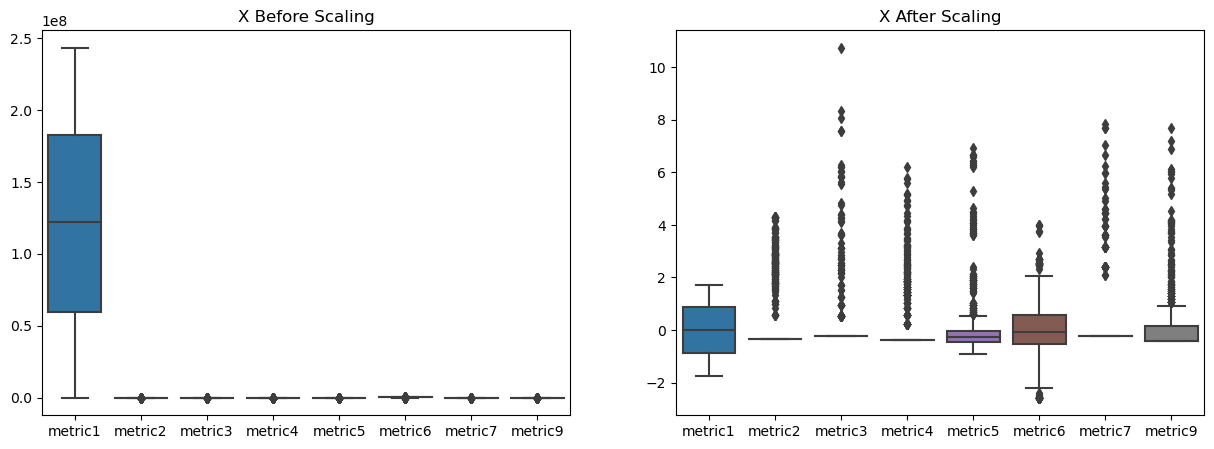

In [57]:
# Plot boxplots to visualize the changes
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=X_before_scaling[numeric_cols])
plt.title('X Before Scaling')
plt.subplot(1, 2, 2)
sns.boxplot(data=X[numeric_cols])
plt.title('X After Scaling')
plt.show()

### Feature Selection

### Feature Importance
You can get the feature importance of each feature of your dataset by using the feature importance property of the model.

Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

Feature importance is an inbuilt class that comes with Tree Based Classifiers, 

In [58]:
# Instantiate ExtraTreesClassifier
model = ExtraTreesClassifier()

# Fit the model to your data
model.fit(X, y)

# Display feature importances
print("Feature Importances:")
print(model.feature_importances_)

Feature Importances:
[4.62595546e-02 7.21152841e-02 1.02379623e-02 8.21059451e-02
 7.37138287e-02 6.18821011e-02 1.19414130e-01 2.19985916e-02
 5.32401943e-03 4.79789178e-03 1.55029667e-02 1.20681563e-02
 1.35564036e-02 9.06691226e-03 3.53822464e-05 3.73895393e-02
 2.30286053e-02 1.91078438e-02 3.75302995e-02 4.11427739e-02
 8.43236540e-02 2.09741316e-02 4.93355944e-03 1.29226366e-02
 5.42340592e-03 5.02450497e-02 2.74791953e-02 4.01020702e-02
 1.96129220e-02 1.74411023e-02 1.02640808e-02]


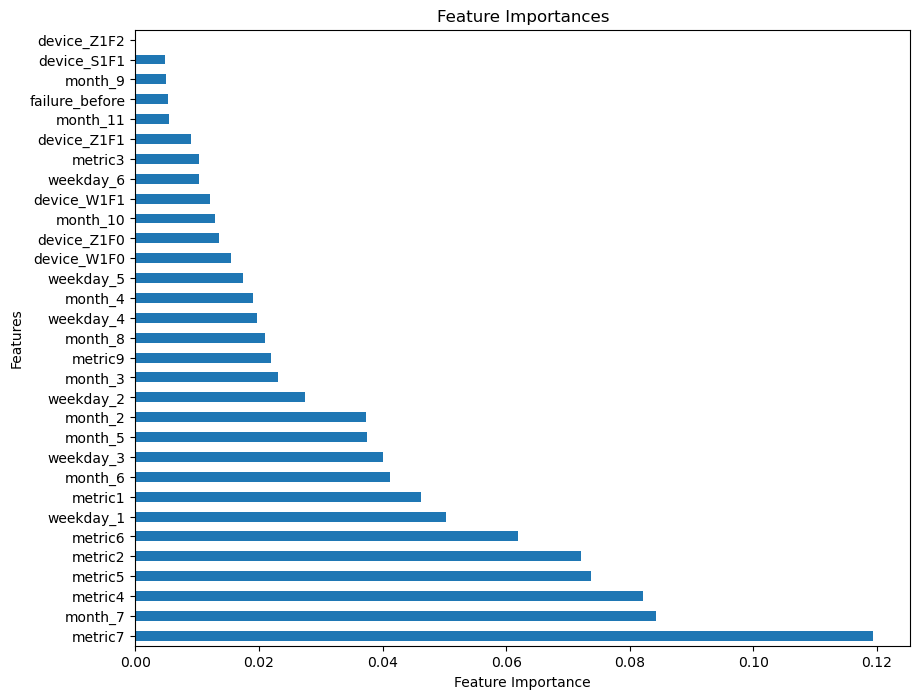

In [59]:
# Plot graph of feature importances for better visualization
plt.figure(figsize=(10, 8))  
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=False).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

In [60]:
# Set threshold value for selecting important features
threshold = 0.005  # Adjust this value as needed

# Select only important features based on the threshold
important_features = feat_importances[feat_importances > threshold].index.tolist()

# Filter the original feature set X to include only the important features
X_selected = X[important_features]

In [61]:
X_selected

metric1   metric2    metric3   metric4   metric5   metric6   metric7  \
3051    0.294754 -0.351631  -0.228395 -0.393875 -0.278688 -0.498611 -0.236793   
3516    1.720234  2.153516  10.746969  5.172304 -0.764091  0.663122 -0.236793   
4673   -1.540918 -0.351631  -0.228395 -0.393875 -0.359588 -0.063393 -0.236793   
4685    1.133592  2.153516  -0.228395 -0.393875 -0.683190  0.682726 -0.236793   
4686   -1.563074  2.265260  -0.228395 -0.393875 -0.602290  0.630570 -0.236793   
...          ...       ...        ...       ...       ...       ...       ...   
124489 -1.475741 -0.351631  -0.228395 -0.393875 -0.197787  0.800857  2.403312   
124490  0.716129  1.566797   4.847560  1.034245 -0.116887  0.600867 -0.236793   
124491 -1.465526  3.205851  -0.228395 -0.393875 -0.116887  0.769347 -0.236793   
124492  1.489116 -0.351631  -0.228395 -0.393875 -0.035987  0.851301 -0.236793   
124493 -1.486220 -0.351631  -0.228395 -0.393875 -0.197787  0.779111 -0.236793   

         metric9  failure_before  device_W1F0  ...  month_7  month_8  \
3051    0.154236               0            1  ...        0        0   
3516    7.179974               0            0  ...        0        0   
4673   -0.416615               0            0  ...        0        0   
4685    0.154236               0            0  ...        0        0   
4686   -0.416615               0            0  ...        0        0   
...          ...             ...          ...  ...      ...      ...   
124489 -0.416615               0            0  ...        0        0   
124490  1.756817               0            0  ...        0        0   
124491 -0.416615               0            0  ...        0        0   
124492 -0.416615               0            0  ...        0        0   
124493 -0.416615               0            0  ...        0        0   

        month_10  month_11  weekday_1  weekday_2  weekday_3  weekday_4  \
3051           0         0          0          0          0          0   
3516           0         0          0          0          0          0   
4673           0         0          0          0          0          0   
4685           0         0          0          0          0          0   
4686           0         0          0          0          0          0   
...          ...       ...        ...        ...        ...        ...   
124489         0         1          0          0          0          0   
124490         0         1          0          0          0          0   
124491         0         1          0          0          0          0   
124492         0         1          0          0          0          0   
124493         0         1          0          0          0          0   

        weekday_5  weekday_6  
3051            1          0  
3516            0          1  
4673            0          0  
4685            0          0  
4686            0          0  
...           ...        ...  
124489          0          0  
124490          0          0  
124491          0          0  
124492          0          0  
124493          0          0  

[1169 rows x 28 columns]

From the feature importances, we can identify the most relevant features for predictive modeling. Adjusting the threshold value allows us to select features based on their importance. However, for this dataset, we retain all features due to the potential loss of predictive power observed when selecting only important features.


## Model Training and Evaluation

## Train-Test Split

Before training the models, we split the data into training and testing sets.

In [81]:
# Train Test Split using the selected important features
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [82]:
X_train.shape,X_test.shape

((876, 31), (293, 31))

## Model Evaluation
Evaluate the performance of three different models: Logistic Regression, Random Forest, and XGBoost, using metrics such as precision, recall, F1-score, and confusion matrix.

Accuracy is not a good measure for unbalanced datasets because a model can achieve high accuracy simply by predicting the majority class for all instances, while failing to correctly predict the minority class, which is often the more important one to detect.

In [83]:
# Define the models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier()
}

# Loop through each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on training and test set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Print model name
    print(model_name)
    print("=" * len(model_name))
    
    # Training set performance
    print("Training Set Performance:")
    print("Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Precision:", precision_score(y_train, y_train_pred))
    print("Recall:", recall_score(y_train, y_train_pred))
    print("F1-score:", f1_score(y_train, y_train_pred))
   
    print("\n")
    
    # Test set performance
    print("Test Set Performance:")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Precision:", precision_score(y_test, y_test_pred))
    print("Recall:", recall_score(y_test, y_test_pred))
    print("F1-score:", f1_score(y_test, y_test_pred))
    print("\n")

Logistic Regression
Training Set Performance:
Accuracy: 0.9474885844748858
Precision: 0.851063829787234
Recall: 0.5063291139240507
F1-score: 0.634920634920635


Test Set Performance:
Accuracy: 0.9488054607508533
Precision: 0.8181818181818182
Recall: 0.4090909090909091
F1-score: 0.5454545454545455


Random Forest
Training Set Performance:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


Test Set Performance:
Accuracy: 0.9590443686006825
Precision: 0.9166666666666666
Recall: 0.5
F1-score: 0.6470588235294118


XGBoost
Training Set Performance:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


Test Set Performance:
Accuracy: 0.9488054607508533
Precision: 0.7692307692307693
Recall: 0.45454545454545453
F1-score: 0.5714285714285714




In [84]:
from sklearn.metrics import classification_report

def evaluate_models(X_train, y_train, X_test, y_test):
    # Define the models
    logistic_model = LogisticRegression(random_state=42)
    random_forest_model = RandomForestClassifier(random_state=42)
    xgb_model = xgb.XGBClassifier(random_state=42)

    # Train the models
    logistic_model.fit(X_train, y_train)
    random_forest_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)

    # Define a dictionary of models
    models = {
        "Logistic Regression": logistic_model,
        "Random Forest": random_forest_model,
        "XGBoost": xgb_model
    }
    
    # Loop through each model
    for model_name, model in models.items():
        # Make predictions
        predictions = model.predict(X_test)

        # Calculate TP, FN, FP, TN
        TP = sum((predictions == 1) & (y_test == 1))
        FN = sum((predictions == 0) & (y_test == 1))
        FP = sum((predictions == 1) & (y_test == 0))
        TN = sum((predictions == 0) & (y_test == 0))

        # Print model name
        print(model_name)
        print("=" * len(model_name))

        # Print classification report
        print("Classification Report:")
        print(classification_report(y_test, predictions))

        # Print TP, FN, FP, TN
        print('TP:', TP)
        print('FN:', FN)
        print('FP:', FP)
        print('TN:', TN)

        print("\n\n")



In [85]:
evaluate_models(X_train, y_train, X_test, y_test)



Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       271
           1       0.82      0.41      0.55        22

    accuracy                           0.95       293
   macro avg       0.89      0.70      0.76       293
weighted avg       0.94      0.95      0.94       293

TP: 9
FN: 13
FP: 2
TN: 269



Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       271
           1       0.91      0.45      0.61        22

    accuracy                           0.96       293
   macro avg       0.93      0.73      0.79       293
weighted avg       0.95      0.96      0.95       293

TP: 10
FN: 12
FP: 1
TN: 270



XGBoost
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       271
           1       0.77      0.45      0.57        22

    accura

## Receiver Operating Characteristic (ROC) Curve
ROC curve for each model to visualize its performance in terms of true positive rate versus false positive rate.

In [86]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_curve(models, X_test, y_test):
    """
    Plot ROC curve for each model.

    Parameters:
    - models (dict): A dictionary containing model names as keys and trained models as values.
    - X_test (DataFrame or array-like): Test features.
    - y_test (Series or array-like): True labels for the test data.
    """
    plt.figure(figsize=(8, 6))
    for model_name, model in models.items():
        # Make predictions
        predictions = model.predict_proba(X_test)[:, 1]
        
        # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, predictions)
        
        # Compute AUC score
        auc_score = roc_auc_score(y_test, predictions)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

    # Plot ROC curve for random guessing (baseline)
    plt.plot([0, 1], [0, 1], linestyle="--", color="grey", label="Random Guessing")

    # Add labels and legend
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.grid(True)
    plt.show()



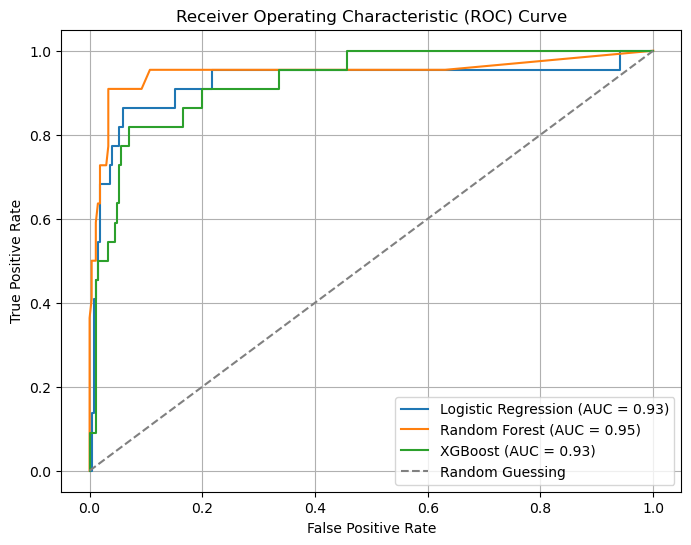

In [87]:
plot_roc_curve(models, X_test, y_test)


### Handling Imbalanced Dataset


## Using Under Sampling
Address the class imbalance issue by undersampling the majority class using the RandomUnderSampler technique.

Undersampling is a simpler and computationally less expensive approach, it may lead to information loss and bias in the model.

In [89]:
from imblearn.under_sampling import RandomUnderSampler

# Define RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Undersample the majority class
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)


In [90]:
X_resampled.shape

(158, 31)

In [91]:
# Call evaluate_models function
evaluate_models(X_resampled, y_resampled, X_test, y_test)

Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       271
           1       0.38      0.73      0.50        22

    accuracy                           0.89       293
   macro avg       0.68      0.82      0.72       293
weighted avg       0.93      0.89      0.91       293

TP: 16
FN: 6
FP: 26
TN: 245



Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       271
           1       0.40      0.86      0.54        22

    accuracy                           0.89       293
   macro avg       0.69      0.88      0.74       293
weighted avg       0.94      0.89      0.91       293

TP: 19
FN: 3
FP: 29
TN: 242



XGBoost
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       271
           1       0.25      0.82      0.38        22

    accur

Random Forest: Best for low false negatives, despite more false positives.

Logistic Regression: Fewer false positives, more false negatives.

XGBoost: High recall, but many false positives.

Choose Random Forest to minimize false negatives, Logistic Regression for fewer false positives.


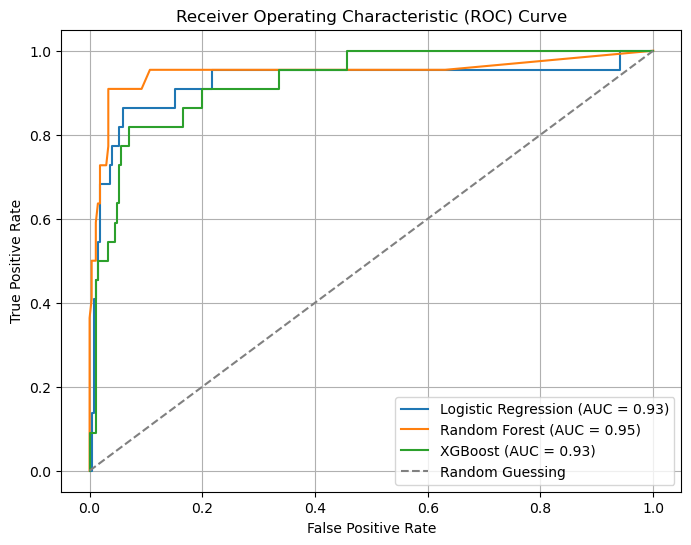

In [92]:
plot_roc_curve(models, X_test, y_test)


## Using SMOTE
SMOTE, an oversampling technique, generates synthetic samples for the minority class, effectively overcoming the overfitting problem of random oversampling, while also preserving information and reducing bias, thereby enhancing the model's overall performance and generalization capability.

In [93]:
from imblearn.over_sampling import SMOTE

In [94]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [95]:
# Check the class distribution after resampling
print("After SMOTE:")
print(y_resampled.value_counts())

After SMOTE:
0    1068
1    1068
Name: failure, dtype: int64


 After resampling, we split the data into train and test sets and evaluate the models' performance again.



In [96]:
# Split the resampled data into train and test sets
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)


In [97]:
X_train_resampled.shape, X_test_resampled.shape

((1602, 31), (534, 31))

In [98]:
evaluate_models(X_train_resampled, y_train_resampled, X_test_resampled, y_test_resampled)


Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       274
           1       0.91      0.92      0.92       260

    accuracy                           0.92       534
   macro avg       0.92      0.92      0.92       534
weighted avg       0.92      0.92      0.92       534

TP: 240
FN: 20
FP: 24
TN: 250



Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       274
           1       0.97      0.97      0.97       260

    accuracy                           0.97       534
   macro avg       0.97      0.97      0.97       534
weighted avg       0.97      0.97      0.97       534

TP: 253
FN: 7
FP: 9
TN: 265



XGBoost
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       274
           1       0.96      0.98      0.97       260

    acc

All models improve with SMOTE, with Random Forest and XGBoost leading. XGBoost excels in minimizing false negatives, critical for failure detection. Random Forest balances false positives and negatives better. Choose based on the cost trade-off between false positives and false negatives.

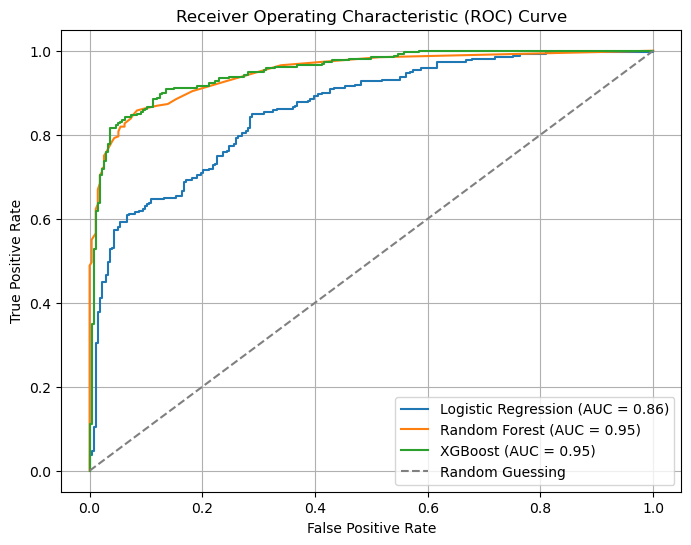

In [99]:
plot_roc_curve(models, X_test_resampled, y_test_resampled)


## Hyperparameter Tuning

I apply hyperparameter tuning to optimize the **Random Forest and XGBoost** models using GridSearchCV.

GridSearchCV systematically searches for the optimal combination of hyperparameters, helping to fine-tune machine learning models effectively. It automates the process of hyperparameter tuning, saving time and effort. Additionally, it helps in avoiding overfitting by finding the best hyperparameters through cross-validation.

In [100]:
from sklearn.model_selection import GridSearchCV

def tune_random_forest(X_train, y_train):
    # Define the parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    # Instantiate the RandomForestClassifier
    rf = RandomForestClassifier()

    # Instantiate GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

    # Fit GridSearchCV to the data
    grid_search.fit(X_train, y_train)

    # Print the best parameters found
    print("Best parameters found:")
    print(grid_search.best_params_)

    # Return the best estimator
    return grid_search.best_estimator_



In [101]:
from sklearn.model_selection import GridSearchCV

def tune_xgboost(X_train, y_train):
    # Define the parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7, 0.9],
        'colsample_bytree': [0.5, 0.7, 0.9]
    }

    # Instantiate the XGBClassifier
    xgb_model = xgb.XGBClassifier()

    # Instantiate GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

    # Fit GridSearchCV to the data
    grid_search.fit(X_train, y_train)

    # Print the best parameters found
    print("Best parameters found:")
    print(grid_search.best_params_)

    # Return the best estimator
    return grid_search.best_estimator_



In [102]:
 best_rf_model = tune_random_forest(X_train_resampled, y_train_resampled)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found:
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [103]:
best_xgb_model = tune_xgboost(X_train_resampled, y_train_resampled)


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}


# Model Evaluation after Hyperparameter Tuning

Evaluate the performance of the tuned models using the test data.

In [104]:
def evaluate_tuned_model(model, X_test, y_test):
    # Make predictions
    predictions = model.predict(X_test)

    # Print classification report
    print("Classification Report: ")
    print(classification_report(y_test, predictions))

    # Calculate TP, FN, FP, TN
    TP = sum((predictions == 1) & (y_test == 1))
    FN = sum((predictions == 0) & (y_test == 1))
    FP = sum((predictions == 1) & (y_test == 0))
    TN = sum((predictions == 0) & (y_test == 0))

    # Print TP, FN, FP, TN
    print('TP:', TP)
    print('FN:', FN)
    print('FP:', FP)
    print('TN:', TN)



In [105]:
evaluate_tuned_model(best_rf_model, X_test_resampled, y_test_resampled)

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       274
           1       0.97      0.98      0.98       260

    accuracy                           0.98       534
   macro avg       0.98      0.98      0.98       534
weighted avg       0.98      0.98      0.98       534

TP: 255
FN: 5
FP: 7
TN: 267


In [109]:
evaluate_tuned_model(best_xgb_model, X_test_resampled, y_test_resampled)

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       274
           1       0.96      0.98      0.97       260

    accuracy                           0.97       534
   macro avg       0.97      0.97      0.97       534
weighted avg       0.97      0.97      0.97       534

TP: 254
FN: 6
FP: 10
TN: 264


Random Forest edges slightly ahead with a better F1-score and fewer false predictions. 

#### Plot the ROC curve for both tuned models using the resampled test data.

In [110]:
# Create a dictionary containing model names as keys and trained models as values
tuned_models = {"Random Forest": best_rf_model, "XGBoost": best_xgb_model}


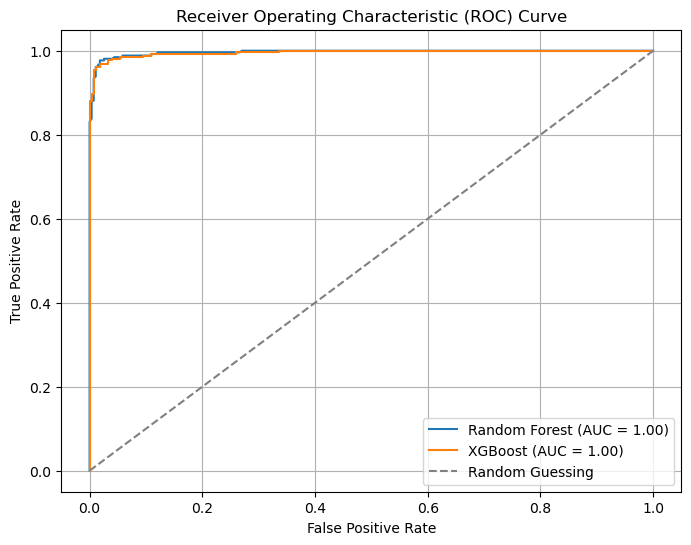

In [111]:
# Plot ROC curve for both tuned models using resampled test data
plot_roc_curve(tuned_models, X_test_resampled, y_test_resampled)


 Both the **Random Forest and XGBoost** models perform excellently after tuning, scoring a perfect **1.00 on ROC AUC**. **Random Forest** edges slightly ahead with a better **F1-score (0.98)** and fewer false predictions. Both models are great for spotting device failures, making them solid choices for real-world use.

 **Finally the goal to minimize the FP and FN achieved**!!